In [1]:
# 2023 Gabriel J. Diaz @ RIT

import os
import sys
import numpy as np

import logging
import pickle
from tqdm import tqdm

import io
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path, PurePath

import sys
sys.path.append('../..')
from flow_source import *

logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
x = 50
plt.rcParams['figure.figsize'] = [640/x, 480 /x]

img_out_path = 'image_out/'

if os.path.exists(img_out_path) is False:
    os.mkdir(img_out_path)

# video_target_path =  r'D:\Github\retinal_flow_toolkit\flow_out\linear_travel\linear_travel_nvidia2_hsv_overlay.mp4'
video_target_path =  r'D:\Github\retinal_flow_toolkit\flow_out\dash_cam\dash_cam_nvidia2_hsv_overlay.mp4'

# video_target_path = r'D:\Github\retinal_flow_toolkit\sandbox\overlay_gaze\dash_cam_nvidia2_hsv_overlay.mp4'
#video_target_path = r'D:\Github\retinal_flow_toolkit\sandbox\overlay_gaze\linear_travel_nvidia2_hsv_overlay.mp4'
video = cv2.VideoCapture(video_target_path)

# number of frames in the video
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )


509


In [3]:
def crop_image_bgr(bgr_image):#, flow):
    # crops off the bad OF estimation from the outer parts of the image
    
    h = np.shape(bgr_image)[0]
    w = np.shape(bgr_image)[1]

    # width of analysis window in proportions of image width/height
    win_size = 0.8

    b = int(h/2 + (win_size*h)/2)
    t = int(h/2 - (win_size*h)/2)
    l = int(w/2 - (win_size*w)/2)
    r = int(w/2 + (win_size*w)/2)

    sm_image = bgr_image[t:b,l:r,:]

    return sm_image


https://notebook.community/joverbee/electromagnetism_course/vector_example

In [4]:

def extract_uv_flow_bgr(image_in,scalar=15):
    
    hsv = cv2.cvtColor(image_in, cv2.COLOR_BGR2HSV)

    mag = scalar * (hsv[..., 2] / 255.0)
    angle = (hsv[..., 0] * np.pi * 2.0) / 180.0 # angles are in radians here

    xmax=np.shape(image)[1]
    xpoints = int(np.shape(image)[1])
    x=np.linspace(0,np.shape(image)[1],xmax)

    ymax=np.shape(image)[0]
    ypoints = int(np.shape(image)[0])
    y=np.linspace(0,np.shape(image)[0],ymax)

    x2d,y2d=np.meshgrid(x,y,indexing='xy')

    u = mag * np.cos(angle) # this is the same as flow[...,0] * mag * -1, as I did above
    v = mag  * np.sin(angle)
    
    return u,v

def show_OF_on_rgb_img(image, frame_num=False, save=False):
    
    # rescale from 0-255 to 0-upper mag threshold (15)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mag = 15 * (hsv[..., 2] / 255.0)
    angle = (hsv[..., 0] * np.pi * 2.0) / 180.0 # angles are in radians here

    xmax=np.shape(image)[1]
    xpoints = int(np.shape(image)[1])
    x=np.linspace(0,np.shape(image)[1],xmax)

    ymax=np.shape(image)[0]
    ypoints = int(np.shape(image)[0])
    y=np.linspace(0,np.shape(image)[0],ymax)

    x2d,y2d=np.meshgrid(x,y,indexing='xy')

    u = mag * np.cos(angle) * -1 # this is the same as flow[...,0] * mag * -1, as I did above
    v = mag  * np.sin(angle)

    skippts=5
    skip=(slice(None,None,skippts),slice(None,None,skippts)) #don't plot all the point as this get too messy
    
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.quiver(x2d[skip], y2d[skip],u[skip],v[skip],color='white',alpha=0.5)
    
    if save:
        plt.savefig(r'image_out\OF_quiver_plot_frame' + str(frame_num) + '.png')
        return
    else:
        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='png')
        return img_buf
    #plt.show()

### Method 1, equal weighting

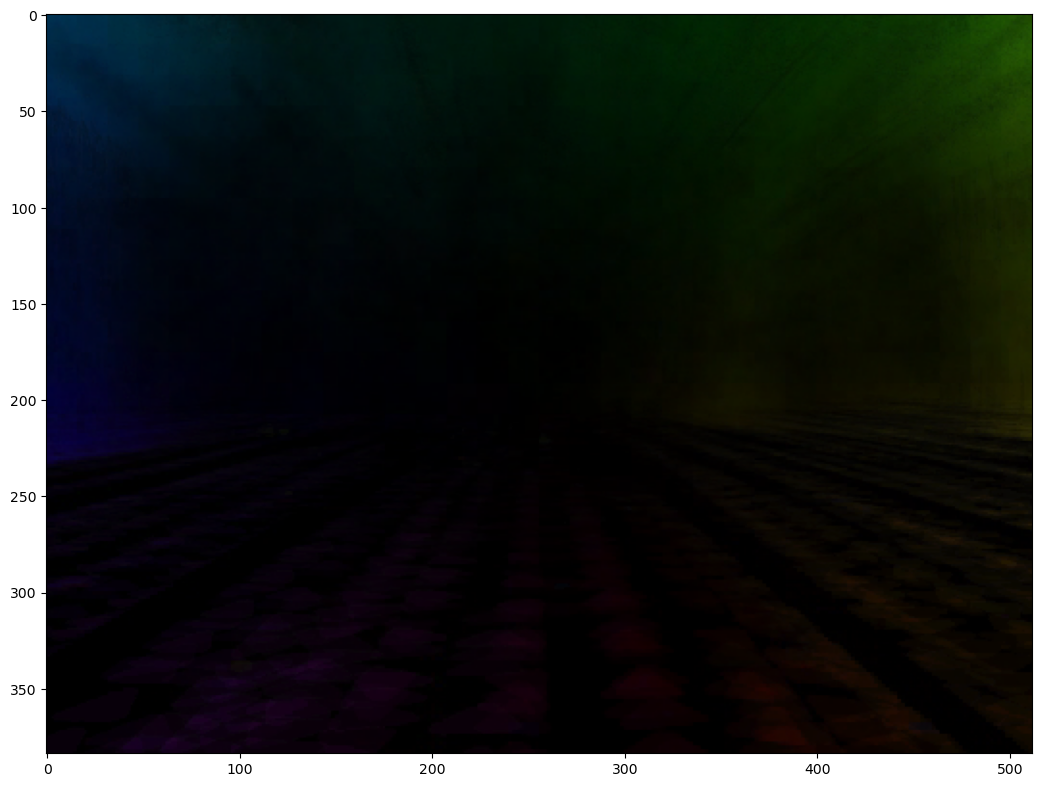

In [5]:
start_at = 100
buffer_length = 30

# print out multiple flow images
from collections import deque
image_buffer = deque([buffer_length])

video.set(cv2.CAP_PROP_POS_FRAMES, start_at)
__, calc_image = video.read()

idx = 1
for f in np.arange(start_at+1,
                   start_at+buffer_length-1):
    
    __, bgr_image = video.read()
#     hsv = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
#     image_buffer.appendleft(hsv)
#     images.append(bgr_image)
    second_weight = 1/(idx+1)
    first_weight = 1 - second_weight
    calc_image =cv2.addWeighted(calc_image, first_weight, bgr_image, second_weight, 0)
    idx+= 1

plt.imshow(crop_image_bgr(calc_image))

## Method 2, mergeMertens exposure fusion

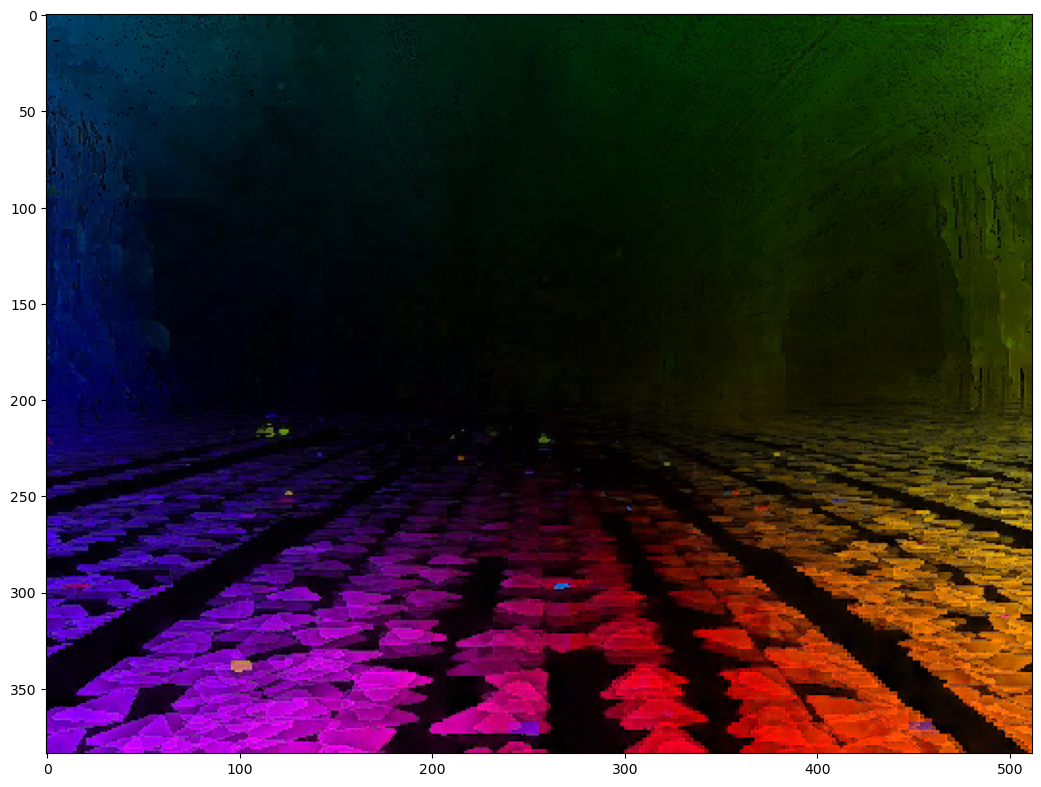

In [6]:
start_at = 100
buffer_length = 30

# print out multiple flow images
from collections import deque
image_buffer = deque([buffer_length])

video.set(cv2.CAP_PROP_POS_FRAMES, start_at)
__, calc_image = video.read()

for f in np.arange(start_at,
                   start_at+buffer_length):
    
    __, bgr_image = video.read()
    image_buffer.appendleft(bgr_image)

 
mergeMertens = cv2.createMergeMertens()
calc_image = mergeMertens.process([img for img in [*image_buffer][:-1]])

calc_image = np.clip(calc_image*255, 0, 255)
calc_image = calc_image.astype('uint8')

plt.imshow(crop_image_bgr(calc_image))

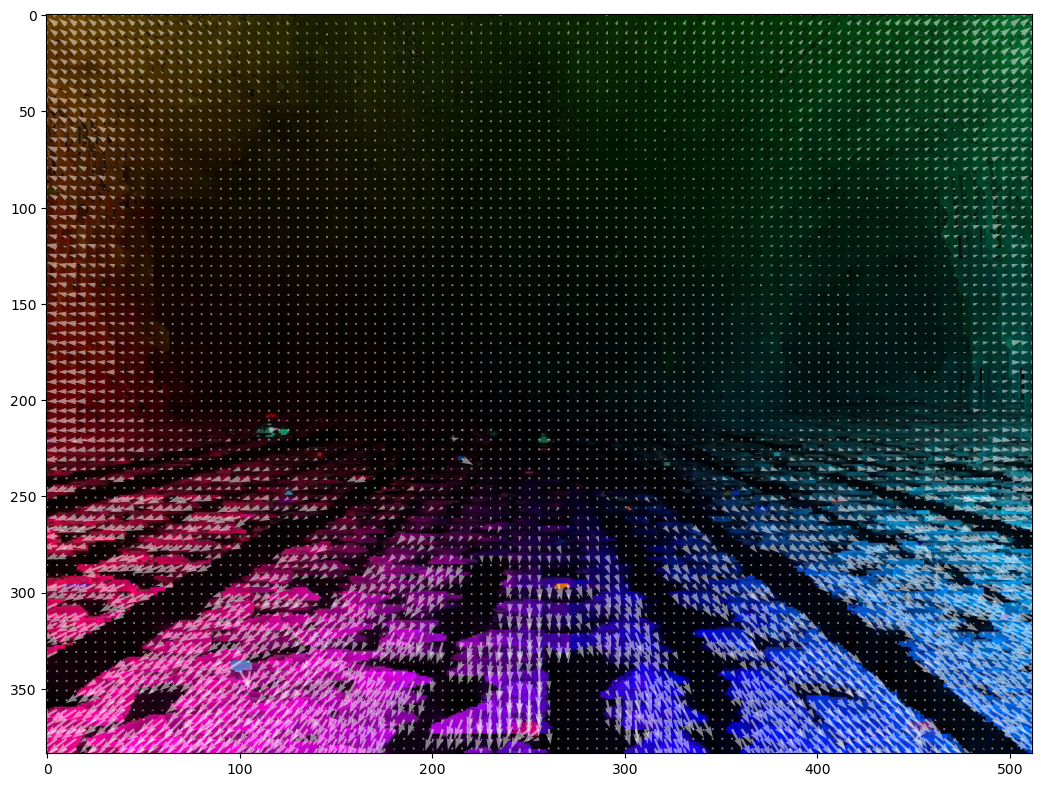

In [7]:
show_OF_on_rgb_img(crop_image_bgr(calc_image))

In [8]:
# https://stackoverflow.com/questions/71990386/calculating-divergence-and-curl-from-optical-flow-and-plotting-it

def divergence_npgrad(u, v):
    dFx_dx = np.gradient(v, axis=0)
    dFy_dy = np.gradient(u, axis=1)
    return dFx_dx + dFy_dy

def curl_npgrad(u, v):    
    dFx_dy = np.gradient(v, axis=1)
    dFy_dx = np.gradient(u, axis=0)
    curl = dFy_dx - dFx_dy
    return curl


In [9]:
image = crop_image_bgr(calc_image)

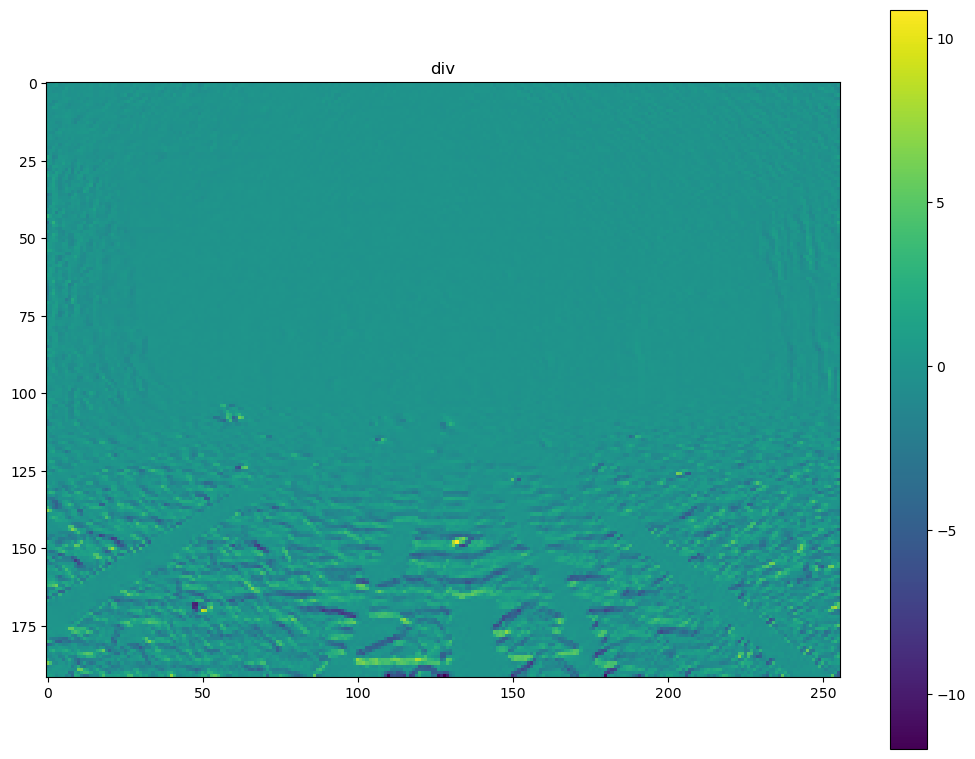

In [10]:
scale = .5

w_h = np.array([np.shape(image)[1] * scale, np.shape(image)[0] * scale], dtype=int)
resized_image = cv2.resize(image, w_h, interpolation= cv2.INTER_LINEAR)

u,v = extract_uv_flow_bgr(resized_image)

div = divergence_npgrad(u,v)
plt.imshow(div,origin='upper')
plt.title('div')
plt.colorbar()
plt.show()


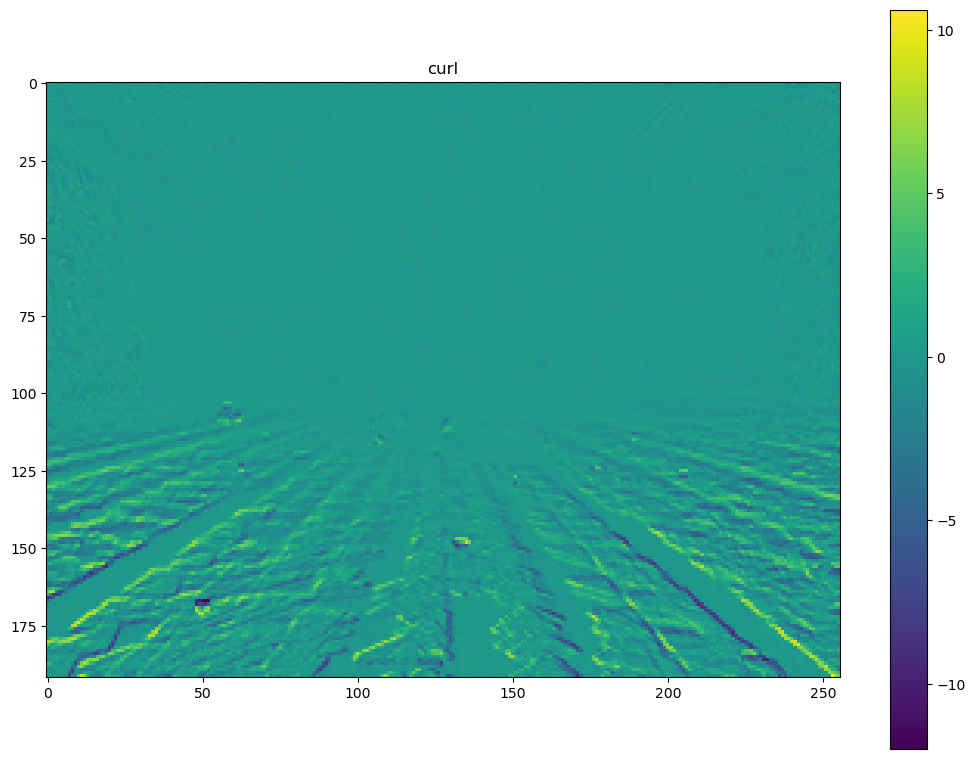

In [11]:
curl = curl_npgrad(u,v)
plt.imshow(curl,origin='upper')
plt.title('curl')
plt.colorbar()
plt.show()

### Scraps

In [12]:
# calc_image = np.zeros(np.shape(image_buffer[0]),dtype=np.float64)

# for i in range(1,len(image_buffer)):
#     calc_image += image_buffer[i]

# # calc_image = np.divide(calc_image, len(image_buffer))
# # calc_image[calc_image[...,0]>0] = 255 

In [13]:
# calc_image[...,0] = np.mean(calc_image[...,0][calc_image[...,0]>0])
# calc_image[...,1] = np.mean(calc_image[...,1][calc_image[...,1]>0])

# # calc_image[...,1] = np.divide(calc_image[...,1], len(image_buffer))
# # calc_image[...,1][calc_image[...,1]>255] = 255
# # calc_image[...,2] = (calc_image[...,2] / np.max(calc_image[...,2])) * 255

# #numpy.clip(a, a_min, a_max, out=None, **kwargs)
# calc_image[...,2] =  np.clip((calc_image[...,2] / 20000), 0, 255)

In [14]:
# calc_image[...,0] = (calc_image[...,0]/np.max(calc_image[...,0])) * 180
# calc_image[...,1] = (calc_image[...,1]/np.max(calc_image[...,1])) * 255
# calc_image[...,2] = np.clip(calc_image[...,2],0,255)


In [15]:
    
# buffer_length = 30
# from collections import deque
# image_buffer = deque([buffer_length])


# start_at = 1
# mergeMertens = cv2.createMergeMertens()
# video.set(cv2.CAP_PROP_POS_FRAMES, start_at)
# __, calc_image = video.read()

# for f in np.arange(start_at+1,
#                    start_at+buffer_length-1):
    
#     __, bgr_image = video.read()
#     hsv = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
#     image_buffer.appendleft(hsv)
#     images.append(bgr_image)
    
#     calc_image = mergeMertens.process(images)
#     calc_image = np.clip(calc_image*255, 0, 255)
#     calc_image = calc_image.astype('uint8')
        
#     cv2.imshow("test", calc_image)
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break


In [16]:
#play_video_with_superimposed_OF()

In [17]:
# def divergence_npgrad(flow):
#     flow = np.swapaxes(flow, 0, 1)
#     Fx, Fy = flow[:, :, 0], flow[:, :, 1]
#     dFx_dx = np.gradient(Fx, axis=0)
#     dFy_dy = np.gradient(Fy, axis=1)
#     return dFx_dx + dFy_dy

# def curl_npgrad(flow):
#     flow = np.swapaxes(flow, 0, 1)
#     Fx, Fy = flow[:, :, 0], flow[:, :, 1]
#     dFx_dy = np.gradient(Fx, axis=1)
#     dFy_dx = np.gradient(Fy, axis=0)
#     curl = dFy_dx - dFx_dy
#     return curl